## Import libraries and set GPU

In [1]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio
import gdown

2023-04-01 21:24:13.587623: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

## Download dataset (GRID corpus)

In [3]:
if not os.path.exists('data.zip'):
    url = 'https://drive.google.com/uc?id=1m5J8VO-7uK3BmaYEh1nX2JBHP35axsh-'
    output = 'data.zip'
    gdown.download(url, output, quiet=False,use_cookies=False)
    gdown.extractall('data.zip')

## Helper functions

In [4]:
def load_video(path):
    """
    Helper function to load a video sequentially as frames and standardize them
    Each frame is cropped to capture around the lip regions to reduce computations
    and improve accuracy
    """
    frames = []
    cap = cv2.VideoCapture(path)
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        _, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:]) # hardcoding the lip coordinates
    cap.release()
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [5]:
def define_vocab_mapping(vocab):
    """
    Helper function to define simple vocabulary mapping for the unique characters in video sequences.
    """
    character_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
    num_to_character = tf.keras.layers.StringLookup(vocabulary=character_to_num.get_vocabulary(), oov_token="", invert=True)
    print(
    f"The vocabulary is: {character_to_num.get_vocabulary()} "
    f"(size ={character_to_num.vocabulary_size()})"
    )
    return character_to_num, num_to_character

In [6]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "] # all set of characters in dataset
char_to_num, num_to_char = define_vocab_mapping(vocab)

Metal device set to: Apple M1
The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


2023-04-01 21:24:17.583587: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-01 21:24:17.583937: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
def load_align(path):
    """
    Helper function to load an alignment and map it with the vocabulary defined
    """
    with open(path, 'r') as f: 
        lines = f.readlines()
    tokens = []
    for line in lines:
        words = line.split(' ')
        if words[2] != 'sil': # ignore timestamps that are marked silence
            tokens = [*tokens,' ',words[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [8]:
def load_data(path):
    """
    Helper function to load frames of a video and corresponding alignments for the path provided.
    """
    path = bytes.decode(path.numpy())
    file_name = path.split('/')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    align_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path)
    alignments = load_align(align_path)
    return frames, alignments[0:40] # trim alignments to 40 window

In [9]:
def mappable_function(path):
    """
    Helper function to wrap `load_data` to a tensorFlow op that executes it eagerly.
    """
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

## Visualize data

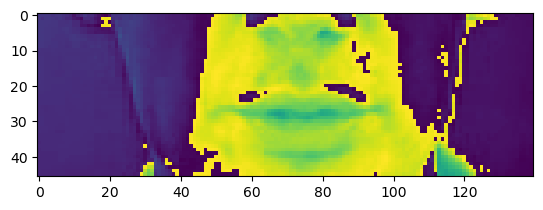

In [10]:
frames, alignments = load_data(tf.convert_to_tensor('data/s1/pwad3s.mpg'))
plt.imshow(frames[45])

In [11]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'sil place white at d three soon s'>

## Data Pipeline

In [12]:
# load all files from folder with .mpg extension
data = tf.data.Dataset.list_files('data/s1/*.mpg')

# shuffle data
data = data.shuffle(500, reshuffle_each_iteration=False)

# map load_data across the elements of dataset
data = data.map(mappable_function)

# pad data frames to 75 and alignments to 40 and create batches with 2 elements
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))

# improve latency by prefetched data
data = data.prefetch(tf.data.AUTOTUNE)

# split into train test batches 900-100 split
train = data.take(450)
test = data.skip(450)

## Model building

In [13]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import LSTM, Dense, MaxPool3D, Conv3D, TimeDistributed, Flatten, Dropout, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.optimizers import Adam

In [14]:
data.as_numpy_iterator().next()[0][0][0].shape
# (75, 46, 140, 1)
# 75 frames, 46 height of each frame, 140 width of each frame, 1 color channel

2023-04-01 21:24:18.889879: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1000]
	 [[{{node Placeholder/_0}}]]
2023-04-01 21:24:18.890372: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1000]
	 [[{{node Placeholder/_0}}]]


(46, 140, 1)

In [15]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same', activation = 'relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same', activation = 'relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same', activation = 'relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

2023-04-01 21:24:22.530596: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-01 21:24:22.531924: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-01 21:24:22.532990: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128)  3584      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 75, 23, 70, 128)  0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 75, 11, 35, 256)  0         
 3D)                                                             
                                                                 
 conv3d_2 (Conv3D)           (None, 75, 11, 35, 75)    518475    
                                                                 
 max_pooling3d_2 (MaxPooling  (None, 75, 5, 17, 75)    0

## Training

In [17]:
def CTCLoss(y_true, y_pred):
    """
    Define custom CTC Loss function
    https://keras.io/examples/audio/ctc_asr/#model
    CTC is an algorithm used to train deep neural networks in speech recognition, 
    handwriting recognition and other sequence problems. CTC is used when we don’t know how 
    the input aligns with the output (how the characters in the transcript align to the audio). 
    """
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [18]:
class ProduceExample(tf.keras.callbacks.Callback):
    """
    Custom callback to print original and predicted alignment after epoch end
    """
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [19]:
def scheduler(epoch, lr):
    """
    Dynamic scheduler to improve training time
    """
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [20]:
# Define optimizer and callbacks
lr = 0.0001
model.compile(optimizer=Adam(learning_rate=lr), loss=CTCLoss)
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True)
schedule_callback = LearningRateScheduler(scheduler)
example_callback = ProduceExample(test)

2023-04-01 21:24:23.272222: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1000]
	 [[{{node Placeholder/_0}}]]
2023-04-01 21:24:23.272737: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1000]
	 [[{{node Placeholder/_0}}]]


In [ ]:
model.fit(train, validation_data=test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])

Epoch 1/100


2023-04-01 21:24:23.308186: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1000]
	 [[{{node Placeholder/_0}}]]
2023-04-01 21:24:23.308696: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1000]
	 [[{{node Placeholder/_0}}]]
2023-04-01 21:24:23.550983: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

2023-04-01 21:24:26.042892: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-01 21:24:26.044481: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-01 21:24:26.045609: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

  9/450 [..............................] - ETA: 7:23:13 - loss: 141.9597